In [6]:
import features_nodewise as nw
import features_pairwise as pw
import preprocessing as prep

import importlib
import matplotlib.pyplot as plt
import random
import numpy as np
import igraph
from sklearn import preprocessing
import nltk
import csv
from functools import reduce
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
import pickle

## Read train / test node pairs
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("./data/train_train_set.csv", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

with open("./data/train_test_set.csv", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

random.seed(0)
training_set = [element[0].split(" ") for element in training_set]
to_keep_train = random.sample( range(len(training_set)),k=int(round(len(training_set)*0.05)) )
training_set_reduced = [training_set[i] for i in to_keep_train]

testing_set = [element[0].split(" ") for element in testing_set]
to_keep_test = random.sample( range(len(testing_set)),k=int(round(len(testing_set)*1)) )
testing_set_reduced = [testing_set[i] for i in to_keep_test]

with open("./data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

publication_years = [int(info[1]) for info in node_info]

corpus = [element[5] for element in node_info]
titles = [element[2] for element in node_info]

t_titles = prep.tfidf(titles)
t = prep.tfidf(corpus)
l = nw.LSA(t)
IDs = [element[0] for element in node_info]
node_dict = prep.to_dict( [element[0] for element in node_info],range(len(node_info)) )
index_dict = prep.to_dict(range(len(IDs)),IDs)


[nltk_data] Downloading package punkt to /home/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'journal_dict' is not defined

In [10]:
#title_sim = t_titles*t_titles.transpose()
importlib.reload(prep)

<module 'preprocessing' from '/home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project/preprocessing.py'>

In [8]:
importlib.reload(pw)


<module 'features_pairwise' from '/home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project/features_pairwise.py'>

In [11]:
# create GOLD STANDARD graphs (train vs test), (reduced vs full)

train_IDs = set([training_set[i][0] for i in range(len(training_set))])
train_IDs = train_IDs | set([training_set[i][1] for i in range(len(training_set))])
train_IDs = list(train_IDs) #igraph doesn't like sets...
train_edges = [(element[0],element[1]) for element in training_set]
train_graph = prep.article_graph(train_IDs,train_edges)

train_IDs_reduced = set([training_set_reduced[i][0] for i in range(len(training_set_reduced))])
train_IDs_reduced = train_IDs_reduced | set([training_set_reduced[i][1] for i in range(len(training_set_reduced))])
train_IDs_reduced = list(train_IDs_reduced)
train_edges_reduced = [(element[0],element[1]) for element in training_set_reduced]
train_graph_reduced = prep.article_graph(train_IDs_reduced,train_edges_reduced)

test_IDs = set([testing_set[i][0] for i in range(len(testing_set))])
test_IDs = test_IDs | set([testing_set[i][1] for i in range(len(testing_set))])
test_IDs = list(test_IDs)
test_edges = [(element[0],element[1]) for element in testing_set]
test_graph = prep.article_graph(test_IDs,test_edges)

test_IDs_reduced = set([testing_set_reduced[i][0] for i in range(len(testing_set_reduced))])
test_IDs_reduced = test_IDs_reduced | set([testing_set_reduced[i][1] for i in range(len(testing_set_reduced))])
test_IDs_reduced = list(test_IDs_reduced)
test_edges_reduced = [(element[0],element[1]) for element in testing_set_reduced]
test_graph_reduced = prep.article_graph(test_IDs_reduced,test_edges_reduced)

'9507159'

In [12]:
## Read all the features that we have stored in files
import os.path

def to_feature_shape(feat):
    feat = np.array(feat)
    if len(feat.shape) == 1:#not a real array but just a long list
        feat = np.reshape(feat,(feat.shape[0],1))
    return feat

#This method should throw an error if something goes wrong
def read_feature(file_path):
    f = open(file_path, 'rb')
    feat = to_feature_shape(pickle.load(f))
    f.close()
    return feat
    
features_to_read = ["overlap_title",
                 "comm_auth",
                 "temp_diff",
                "citation_check",
                "max_sim",
                "peer_popularity",
                "edge_check",
                "LSA_distance",
                "node_degree",
                "succ_pred",
                "temporal_fit"]

train_features_dict = dict()
train_features_reduced_dict = dict()
test_features_dict = dict()
test_features_reduced_dict = dict()
for name in features_to_read:
    # Train
    file_path = './features_train/'+name
    try:
        this_feat = read_feature(file_path)
        train_features_dict[name] = this_feat
        train_features_reduced_dict[name] = this_feat[to_keep_train,:]
    except:
        pass
    # Train reduced
    file_path = './features_train/'+name+'_reduced'
    try:
        this_feat = read_feature(file_path)
        train_features_reduced_dict[name] = this_feat
    except:
        pass
    # Test
    file_path = './features_test/'+name
    try:
        this_feat = read_feature(file_path)
        test_features_dict[name] = this_feat
        test_features_reduced_dict[name] = this_feat[to_keep_test,:]
    except:
        pass
    # Test reduced
    file_path = './features_test/'+name+'_reduced'
    try:
        this_feat = read_feature(file_path)
        test_features_reduced_dict[name] = this_feat
    except:
        pass

NameError: name 'train_true_labels' is not defined

In [13]:
train_true_labels = read_feature('./features_train/true_labels')
train_true_labels = np.reshape(train_true_labels,(train_true_labels.shape[0],))
train_true_labels_reduced = train_true_labels[to_keep_train]
test_true_labels = read_feature('./features_test/true_labels')
test_true_labels = np.reshape(test_true_labels,(test_true_labels.shape[0],))
test_true_labels_reduced = test_true_labels[to_keep_test]

In [33]:
###################################
### Precompute Journal features ###
###################################
journals = [info[4] for info in node_info]
journal_dict, journal_features = prep.journal_features(journals,node_dict,training_set)

0.3047619047619048


In [35]:
############################################
###  Construct features on TRAINING_SET  ###
############################################

#Build KDTree on training_set
train_l = [l[node_dict[i]] for i in train_IDs]
train_kdtree = nw.KDTree(train_l)

train_true_labels = []
features_to_create = ['journal_cites']
# Where to insert created features
insert_features_dict = train_features_dict
for feat in features_to_create:
    insert_features_dict[feat] = []
set_to_use = training_set

for i,triple in enumerate(set_to_use):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    
    source_info = node_info[index_source]
    target_info = node_info[index_target]

    # convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]

    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]

    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",") 
    
    source_journal = source_info[4]
    target_journal = target_info[4]
    
    # Creating features
    # Baseline #
    #overlap_title = len(set(source_title).intersection(set(target_title)))
    #insert_features_dict["overlap_title"].append(overlap_title)
    #temp_diff = int(source_info[1]) - int(target_info[1])
    #insert_features_dict["temp_diff"].append(temp_diff)
    #comm_auth = len(set(source_auth).intersection(set(target_auth)))
    #insert_features_dict["comm_auth"].append(comm_auth)

    #peer_pop = pw.peer_popularity(train_graph,source,target)
    #insert_features_dict["peer_popularity"].append(peer_pop)

    #max_sim = pw.Max_Sim(source,target,l,train_graph,node_dict)
    #insert_features_dict["max_sim"].append(max_sim)

    #edge_check = pw.edge_check(source,target,train_graph)
    #insert_features_dict["edge_check"].append(edge_check)

    #LSA_dist = pw.LSA_distance(source,target,node_dict,l)
    #insert_features_dict["LSA_distance"].append(LSA_dist)
    
    #title_weighted = title_sim[index_source,index_target]
    #insert_features_dict["title_sim"].append(title_weighted)
    
    #citation_check = pw.Citation_Check(source,target,train_kdtree,l,train_graph,node_dict,index_dict,k=500)
    #insert_features_dict["citation_check"].append(citation_check)

    #degree = pw.node_degree(source,target,train_graph)
    #insert_features_dict["node_degree"].append(degree)

    #succ_pred = pw.succ_pred(source,target,train_graph)
    #insert_features_dict["succ_pred"].append(succ_pred)
    
    #temp_fit = pw.temp_fit(source,target,train_graph,node_dict,publication_years)
    #insert_features_dict['temporal_fit'].append(temp_fit)
    
    journal_cites = journal_features[journal_dict[source_journal],journal_dict[target_journal]]
    insert_features_dict["journal_cites"].append(journal_cites)
    
    train_true_labels.append(triple[2])

    if i%1000==0:
        print(i,"/",len(set_to_use))

# Reshape features into np column arrays, one row per node pair
for (name,value) in insert_features_dict.items():
    print(name,len(value))
    insert_features_dict[name] = to_feature_shape(value)
        
# Concatenate all features
feats_train = np.concatenate([feat for feat in insert_features_dict.values()])
train_true_labels = np.array(train_true_labels)

0 / 554602
1000 / 554602
2000 / 554602
3000 / 554602
4000 / 554602
5000 / 554602
6000 / 554602
7000 / 554602
8000 / 554602
9000 / 554602
10000 / 554602
11000 / 554602
12000 / 554602
13000 / 554602
14000 / 554602
15000 / 554602
16000 / 554602
17000 / 554602
18000 / 554602
19000 / 554602
20000 / 554602
21000 / 554602
22000 / 554602
23000 / 554602
24000 / 554602
25000 / 554602
26000 / 554602
27000 / 554602
28000 / 554602
29000 / 554602
30000 / 554602
31000 / 554602
32000 / 554602
33000 / 554602
34000 / 554602
35000 / 554602
36000 / 554602
37000 / 554602
38000 / 554602
39000 / 554602
40000 / 554602
41000 / 554602
42000 / 554602
43000 / 554602
44000 / 554602
45000 / 554602
46000 / 554602
47000 / 554602
48000 / 554602
49000 / 554602
50000 / 554602
51000 / 554602
52000 / 554602
53000 / 554602
54000 / 554602
55000 / 554602
56000 / 554602
57000 / 554602
58000 / 554602
59000 / 554602
60000 / 554602
61000 / 554602
62000 / 554602
63000 / 554602
64000 / 554602
65000 / 554602
66000 / 554602
67000 / 

520000 / 554602
521000 / 554602
522000 / 554602
523000 / 554602
524000 / 554602
525000 / 554602
526000 / 554602
527000 / 554602
528000 / 554602
529000 / 554602
530000 / 554602
531000 / 554602
532000 / 554602
533000 / 554602
534000 / 554602
535000 / 554602
536000 / 554602
537000 / 554602
538000 / 554602
539000 / 554602
540000 / 554602
541000 / 554602
542000 / 554602
543000 / 554602
544000 / 554602
545000 / 554602
546000 / 554602
547000 / 554602
548000 / 554602
549000 / 554602
550000 / 554602
551000 / 554602
552000 / 554602
553000 / 554602
554000 / 554602
overlap_title 554602
comm_auth 554602
temp_diff 554602
peer_popularity 554602
edge_check 554602
LSA_distance 554602
succ_pred 554602
temporal_fit 554602
journal_cites 554602


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [273]:
   train_features_reduced_dict['LSA_distance'].shape

(27730, 1)

In [58]:
############################################
###   Write features to disk - Training  ###
############################################
import os
import pickle

def write_feature_to_disk(feat,file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(feat,file)

print("Current wd: ",os.getcwd())
write_feature_to_disk(train_features_dict['journal_cites'],'./features_train/journal_cites')

Current wd:  /home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project


In [233]:
importlib.reload(pw)

<module 'features_pairwise' from '/home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project/features_pairwise.py'>

In [36]:
###########################################
###  Construct features on TESTING_SET  ###
###########################################

#Build KDTree on training_set
train_l = [l[node_dict[i]] for i in train_IDs]
train_kdtree = nw.KDTree(train_l)

test_true_labels = []
features_to_create = ['journal_cites']

# Where to insert created features
insert_features_dict = test_features_dict
for feat in features_to_create:
    insert_features_dict[feat] = []
set_to_use = testing_set

test_true_labels = []
for i,triple in enumerate(set_to_use):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    
    source_info = node_info[index_source]
    target_info = node_info[index_target]

    # convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]

    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]

    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",") 
    
    source_journal = source_info[4]
    target_journal = target_info[4]
    
    
    # Creating features
    # Baseline #
    #overlap_title = len(set(source_title).intersection(set(target_title)))
    #insert_features_dict["overlap_title"].append(overlap_title)
    #temp_diff = int(source_info[1]) - int(target_info[1])
    #insert_features_dict["temp_diff"].append(temp_diff)
    #comm_auth = len(set(source_auth).intersection(set(target_auth)))
    #insert_features_dict["comm_auth"].append(comm_auth)

    #peer_pop = pw.peer_popularity(train_graph,source,target)
    #insert_features_dict["peer_popularity"].append(peer_pop)

    #max_sim = pw.Max_Sim(source,target,l,train_graph,node_dict)
    #insert_features_dict["max_sim"].append(max_sim)

    #edge_check = pw.edge_check(source,target,train_graph)
    #insert_features_dict["edge_check"].append(edge_check)

    #LSA_dist = pw.LSA_distance(source,target,node_dict,l)
    #insert_features_dict["LSA_distance"].append(LSA_dist)
    
    #title_weighted = title_sim[index_source,index_target]
    #insert_features_dict["title_sim"].append(title_weighted)
    
    #citation_check = pw.Citation_Check(source,target,train_kdtree,l,train_graph,node_dict,index_dict,k=500)
    #insert_features_dict["citation_check"].append(citation_check)
    
    #succ_pred = pw.succ_pred(source,target,train_graph)
    #insert_features_dict["succ_pred"].append(succ_pred)
    
    #degree = pw.node_degree(source,target,train_graph)
    #insert_features_dict["node_degree"].append(degree)

    #temp_fit = pw.temp_fit(source,target,train_graph,node_dict,publication_years)
    #insert_features_dict['temporal_fit'].append(temp_fit)
    
    journal_cites = journal_features[journal_dict[source_journal],journal_dict[target_journal]]
    insert_features_dict["journal_cites"].append(journal_cites)
    
    test_true_labels.append(triple[2])

    if i%1000==0:
        print(i,"/",len(set_to_use))

# Reshape features into np column arrays, one row per node pair
for (name,value) in insert_features_dict.items():
    print(name,len(value))
    insert_features_dict[name] = to_feature_shape(value)
        
# Concatenate all features
feats_test = np.concatenate([feat for feat in insert_features_dict.values()])
test_true_labels = np.array(test_true_labels)

0 / 60910
1000 / 60910
2000 / 60910
3000 / 60910
4000 / 60910
5000 / 60910
6000 / 60910
7000 / 60910
8000 / 60910
9000 / 60910
10000 / 60910
11000 / 60910
12000 / 60910
13000 / 60910
14000 / 60910
15000 / 60910
16000 / 60910
17000 / 60910
18000 / 60910
19000 / 60910
20000 / 60910
21000 / 60910
22000 / 60910
23000 / 60910
24000 / 60910
25000 / 60910
26000 / 60910
27000 / 60910
28000 / 60910
29000 / 60910
30000 / 60910
31000 / 60910
32000 / 60910
33000 / 60910
34000 / 60910
35000 / 60910
36000 / 60910
37000 / 60910
38000 / 60910
39000 / 60910
40000 / 60910
41000 / 60910
42000 / 60910
43000 / 60910
44000 / 60910
45000 / 60910
46000 / 60910
47000 / 60910
48000 / 60910
49000 / 60910
50000 / 60910
51000 / 60910
52000 / 60910
53000 / 60910
54000 / 60910
55000 / 60910
56000 / 60910
57000 / 60910
58000 / 60910
59000 / 60910
60000 / 60910
overlap_title 60910
comm_auth 60910
temp_diff 60910
citation_check 60910
max_sim 60910
peer_popularity 60910
edge_check 60910
LSA_distance 60910
succ_pred 6091

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [68]:
###########################################
###   Write features to disk - Testing  ###
###########################################
import os
import pickle

def write_feature_to_disk(feat,file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(feat,file)

print("Current wd: ",os.getcwd())
write_feature_to_disk(test_features_dict['journal_cites'],'./features_test/journal_cites')

Current wd:  /home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project


(27730, 2)

In [49]:
#Combine all features to one vector
train_features_reduced_dict.keys()
test_features_dict.keys()
for key,feat in train_features_reduced_dict.items():
    print(key,feat.shape[1])
train_features_reduced = np.concatenate([train_features_reduced_dict['overlap_title'],
                                         train_features_reduced_dict['comm_auth'],
                                         train_features_reduced_dict['temp_diff'],
                                         train_features_reduced_dict['citation_check'],
                                         train_features_reduced_dict['max_sim'],
                                         train_features_reduced_dict['peer_popularity'],
                                         train_features_reduced_dict['edge_check'],
                                         train_features_reduced_dict['succ_pred'],
                                         train_features_reduced_dict['LSA_distance'],
                                         train_features_reduced_dict['temporal_fit'],
                                         train_features_reduced_dict['journal_cites']]
                                        ,axis = 1)

test_features = np.concatenate(        [test_features_dict['overlap_title'],
                                        test_features_dict['comm_auth'],
                                        test_features_dict['temp_diff'],
                                        test_features_dict['citation_check'],
                                        test_features_dict['max_sim'],
                                        test_features_dict['peer_popularity'],
                                        test_features_dict['edge_check'],
                                        test_features_dict['succ_pred'],
                                        test_features_dict['LSA_distance'],
                                        test_features_dict['temporal_fit'],
                                        test_features_dict['journal_cites']]
                                        ,axis = 1)

overlap_title 1
comm_auth 1
temp_diff 1
citation_check 4
max_sim 9
peer_popularity 1
edge_check 1
LSA_distance 1
succ_pred 4
temporal_fit 2
journal_cites 2


<module 'features_pairwise' from '/home/lucas/Documents/École Polytechnique/Courses/ML1/Challenge/git_repository/ML_project/features_pairwise.py'>

In [51]:
train_features_reduced.shape

(27730, 27)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_features_reduced)
normalized_train_features = scaler.transform(train_features_reduced)
scaler.fit(test_features)
normalized_test_features = scaler.transform(test_features)

In [67]:
from sklearn import svm

classifier = svm.LinearSVC()
#selection = [0, 1, 16, 20, 22, 23, 24]
selection = [25,26]

classifier.fit(normalized_train_features[:,selection], train_true_labels_reduced)
preds_svm = list(classifier.predict(normalized_test_features[:,selection]))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_svm)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_svm)))
print('acc:',acc,'f1:',f1)

acc: 0.6700377606304384 f1: 0.7147520508671832


In [342]:
from sklearn.linear_model import LogisticRegression as lr
selection = [0, 3, 4, 8, 13, 16, 20, 22, 23, 24]
model = lr().fit(normalized_train_features[:,selection], train_true_labels_reduced)
preds_lg = list(model.predict(normalized_test_features[:,selection]))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_lg)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_lg)))
print('acc:',acc,'f1:',f1)

acc: 0.9511410277458545 f1: 0.9543754215980866


In [343]:
from sklearn.neighbors import KNeighborsClassifier
selection = [1, 2, 6, 13, 16, 20, 21, 22]
nNhbr = KNeighborsClassifier()
nNhbr.fit(train_features_reduced[:,selection],train_true_labels_reduced) # do Ytrain.ravel() for length one Y values
preds_knn = nNhbr.predict(test_features[:,selection])
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_knn)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_knn)))
print('acc:',acc,'f1:',f1)

acc: 0.9420456411098341 f1: 0.9455901846542741


In [344]:
from sklearn.tree import DecisionTreeClassifier
selection = [0, 1, 2, 8, 13, 16, 20, 22]
dTree = DecisionTreeClassifier()
dTree.fit(train_features_reduced[:,selection],train_true_labels_reduced) # do Ytrain.ravel() for length one Y values
preds_dt = dTree.predict(test_features[:,selection])
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_dt)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_dt)))
print('acc:',acc,'f1:',f1)

acc: 0.9338368084058447 f1: 0.9387426278348634


In [345]:
# Joined forces
joined_DTree = DecisionTreeClassifier()

preds_test_svm = np.reshape(preds_svm,(len(preds_svm),1))
preds_test_lg = np.reshape(preds_lg,(len(preds_lg),1))
preds_test_knn = np.reshape(preds_knn,(len(preds_knn),1))
preds_test_dt = np.reshape(preds_dt,(len(preds_dt),1))
combined_preds = np.concatenate([preds_test_svm,preds_test_lg,preds_test_knn,preds_test_dt],axis=1)

joined_DTree.fit(combined_preds[0:50000,:], test_true_labels[0:50000])
preds_joined = joined_DTree.predict(combined_preds[50000:,:])

acc = metrics.accuracy_score(list(map(int,test_true_labels[50000:])), list(map(int,preds_joined)))
f1 = metrics.f1_score(list(map(int,test_true_labels[50000:])), list(map(int,preds_joined)))
print("acc:",acc,"f1:",f1)

acc: 0.9540788267644363 f1: 0.9573653306101607


acc: 0.7900837300935807 f1: 0.7648075932602457
features:  [13, 1, 8, 16, 15, 12, 14]
acc: 0.8700213429650304 f1: 0.8682498211046579
features:  [15, 11, 18, 6, 16]
acc: 0.9041208340174027 f1: 0.9051424487541825
features:  [20, 0, 15, 10, 7, 17, 11]
acc: 0.9397143326219012 f1: 0.942607064707721
features:  [2, 20, 4, 18, 1, 19, 14, 11]
acc: 0.9424560827450337 f1: 0.9457673799687447
features:  [11, 6, 14, 20, 2, 1, 18, 0]

number of classifiers:  1359
number of accs > 0.9: 118


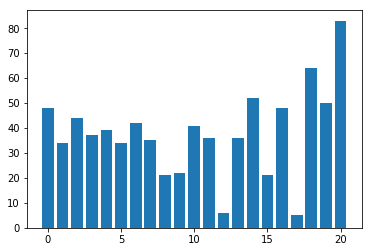

In [110]:
# Select random features and train a decision tree on it
from time import clock

random.seed(0)
total_num_features = train_features_reduced.shape[1]
time_limit = 600
start_time = clock()
feature_selections = []
accs = []
f1s = []
while clock() < start_time + time_limit:
    num_select_features = random.randint(1,10)
    selection = random.sample(range(total_num_features),num_select_features)
    
    model = lr().fit(train_features_reduced[:,selection], train_true_labels_reduced)
    preds = list(model.predict(test_features[:,selection]))

    #nNhbr = KNeighborsClassifier()
    #nNhbr.fit(train_features_reduced[:,selection],train_true_labels_reduced) # do Ytrain.ravel() for length one Y values
    #preds = nNhbr.predict(test_features[:,selection])
    
    #classifier = svm.LinearSVC()
    #classifier.fit(train_features_reduced[:,selection], train_true_labels_reduced)
    #preds = list(classifier.predict(test_features[:,selection]))

    #dTree = DecisionTreeClassifier()
    #dTree.fit(train_features_reduced[:,selection],train_true_labels_reduced)
    #preds = dTree.predict(test_features[:,selection])
    
    acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
    f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
    accs.append(acc)
    f1s.append(f1)
    feature_selections.append(selection)
    if acc == max(accs):
        print('acc:',acc,'f1:',f1)
        print('features: ',selection)


number of classifiers:  1023
number of accs > 0.93 :  335


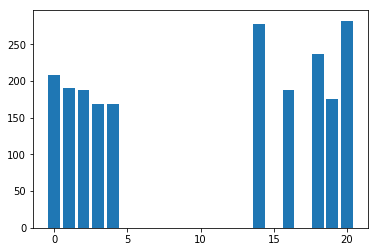

In [179]:
# Which features are important?
# Histogram of the feature frequency for all selections that reached > 90% acc
frequency = [0]*total_num_features

num_good_preds = 0
min_acc = 0.93
for i,acc in enumerate(accs):
    if acc > min_acc:
        num_good_preds += 1
        for f in feature_selections[i]:
            frequency[f] += 1
#frequency = [freq/num_good_preds for freq in frequency]
print("")
print("number of classifiers: ",len(accs))
print("number of accs >",min_acc,": ",sum([1 for acc in accs if acc > min_acc]))
plt.figure()
plt.bar(x=range(len(frequency)),height=frequency)
plt.show()

In [46]:
# Select random features and train a decision tree on it
from time import clock
import itertools

random.seed(0)
total_num_features = train_features_reduced.shape[1]
selection = [0,1,2,5,6,16,18,20,21,22]
time_limit = 600
start_time = clock()
feature_selections = []
#accs = []
#f1s = []
model_number = 0
for r in range(len(selection)+1):
    if r == 0:
        continue
    print(r)
    for c in itertools.combinations(selection,r):
        print("Model ",model_number," out of ",2**len(selection))
        model_number += 1
        sub_selection = list(c)
        #classifier = svm.LinearSVC()
        #classifier.fit(train_features_reduced[:,sub_selection], train_true_labels_reduced)
        #preds = list(classifier.predict(test_features[:,sub_selection]))

        #acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
        #f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
        #accs.append(acc)
        #f1s.append(f1)
        feature_selections.append(sub_selection)
        if acc == max(accs):
            print('acc:',acc,'f1:',f1)
            print('features: ',sub_selection)


1
Model  0  out of  1024


NameError: name 'accs' is not defined

[0.9456082745033656,
 0.9460187161385651,
 0.9459694631423412,
 0.9457396158266295,
 0.9459037924807092,
 0.9457067804958135,
 0.9459530454769332,
 0.9453948448530619,
 0.9458052864882613,
 0.9459858808077491]

In [225]:
# Adaboost DecisionTrees
from sklearn.ensemble import AdaBoostClassifier
selection = [1, 2, 6, 13, 16, 20, 22, 0]
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=500,learning_rate=0.1)
ada.fit(normalized_train_features[:,selection],train_true_labels_reduced)
preds_ada = ada.predict(normalized_test_features[:,selection])
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_ada)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_ada)))
print("acc:",acc,"f1:",f1)

acc: 0.9572812346084387 f1: 0.9604270592529505


In [49]:
# Adaboost LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
selection = [0, 1, 2, 8, 13, 16, 20, 22]
ada = AdaBoostClassifier(lr(),n_estimators=500,learning_rate=1)
ada.fit(train_features_reduced[:,selection],train_true_labels_reduced)
preds_ada = ada.predict(test_features[:,selection])
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_ada)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_ada)))
print("acc:",acc,"f1:",f1)

acc: 0.9196847808241668 f1: 0.9239593372089409


In [50]:
# ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
selection = [1, 2, 6, 13, 16, 20, 22, 0]
extraTrees = ExtraTreesClassifier(n_estimators=100)
extraTrees.fit(train_features_reduced[:,selection],train_true_labels_reduced)
preds_extra = extraTrees.predict(test_features[:,selection])
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds_extra)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds_extra)))
print("acc:",acc,"f1:",f1)

acc: 0.9540305368576588 f1: 0.9574519815220034


In [ ]:
import tensorflow as tf
import numpy as np
import time
import math


class Class_Net():

    def __init__(self, learning_rate=0.001, batch_size=60):
        ''' initialize the classifier with default (best) parameters '''
        tf.reset_default_graph()
        self.alpha = learning_rate
        self.beta = batch_size
        self.warm = False

    def fit(self,X,Y,warm_start=True,n_epochs=50):
        ''' train the network, and if warm_start, then do not reinit. the network
            (if it has already been initialized)
        '''
        self.epochs=n_epochs

        self.n_batch = int(len(X)/self.beta)
        
        if warm_start==False or self.warm==False:
            self.x = tf.placeholder(tf.float32,shape=[None,len(X[0])])
            self.y = tf.placeholder(tf.float32,shape=[None,1])
            
            self.wZero = tf.get_variable('wZero',shape=[len(X[0]),50],initializer=tf.glorot_uniform_initializer())
            self.bZero = tf.Variable(tf.zeros([50]))

            self.wOne = tf.get_variable('wOne',shape=[50,1],initializer=tf.glorot_uniform_initializer())
            self.bOne = tf.Variable(tf.zeros([1]))
            self.keep_prob = 0.9
            self.drop_out = tf.nn.dropout(self.x, self.keep_prob)
            self.model = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(self.drop_out, self.wZero) 
                                              + self.bZero),self.wOne)+self.bOne)
            self.cost = tf.losses.log_loss(self.y,self.model)
            
#             self.optimizer = tf.train.GradientDescentOptimizer(self.alpha).minimize(self.cost)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.alpha).minimize(self.cost)

            #without dropout
#             self.model = tf.matmul(tf.nn.relu(tf.matmul(self.x, self.wZero) + self.bZero),self.wOne)+self.bOne

    
            self.saver = tf.train.Saver()
            self.init = tf.global_variables_initializer()
            
        with tf.Session() as sess:
            if warm_start==False or self.warm==False:
                sess.run(self.init)
            else:
                self.saver.restore(sess, './tempVariables.ckpt')
            for epoch in range(self.epochs):
                self.avg_cost = 0
                for i in range(self.n_batch):
                    _, self.c = sess.run([self.optimizer,self.cost], feed_dict={self.x: X[i*self.beta:min([(i+1)*
                                    self.beta,len(X)]),:],self.y:Y[i*self.beta:min([(i+1)*self.beta,len(X)])]})
                    
                    self.avg_cost = self.avg_cost+np.mean(self.c)/self.n_batch
                print("Epoch:", '%s' % (epoch+1), "cost=", "%s"% (self.avg_cost))
            self.saver.save(sess,'./tempVariables.ckpt')
            
        self.warm = True
        
        return self
    
    def predict_proba(self,X):
        ''' return a matrix P where P[i,j] = P(Y[i,j]=1), 
        for all instances i, and labels j. '''

        with tf.Session() as sess:
            self.saver.restore(sess, './tempVariables.ckpt')
            self.preds = sess.run(tf.nn.softmax(self.model), feed_dict={self.x: X}) 
        return self.preds
    
    def predict(self,X):
        ''' return a matrix of predictions for X '''
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    


In [ ]:
net = Class_Net(learning_rate=0.01,batch_size=250)
net.fit(features,list(map(lambda x: [x],true_labels)),n_epochs=35)
preds=net.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)